## Scenario7 - Study Optimal drone formation

In [2]:
from scipy.optimize import least_squares
import numpy as np
import time
from pandas import DataFrame
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import sem
from sklearn import  linear_model
import ast
from scipy.optimize import curve_fit
import time
import random

# Util methods

### Method to generate drone position required for simulation

In [28]:
def fun_generate_drone_pos(drone_count):
    lpos = []
    for i in range(drone_count):
        xy=np.random.uniform(1,8,2)
        x=xy[0]
        y=xy[1]
        z=np.random.uniform(2,7,1)[0]
        lpos.append(x)
        lpos.append(y)
        lpos.append(z)
    #print(lpos)
    return (np.asarray(lpos).reshape(1,drone_count, 3))
#fun_generate_drone_pos()

### Calculate the time-of-flight data with the actual drone position and ground object location

In [4]:
def calc_timelags_noisedp(n, dp_orig, dp_noise):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-dp_orig[0][i])**2)) * 2 
                pos1 = dp_noise[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-dp_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-dp_orig[0][inner-1])**2))
                pos1 = dp_noise[0][outer-1]
                pos2 = dp_noise[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y
    
#y = [9.095598162479572,9.282884570730419,12.974780298767472,5.403702434442518,12.787493890516625,13.162066707018319]

### Calculate the difference bw actual and recovered object location

In [5]:
def calc_recored_go_pos_err(actual_go,recovered_go):
    sq_diff=((actual_go-recovered_go)**2)
    total_sum_go_err = np.sqrt(  sq_diff[0]) + np.sqrt( sq_diff[1]) + np.sqrt( sq_diff[2])
    return total_sum_go_err

### Objective function to recover the object location - the function takes input as initial guess of object location, drone coordinates, time-of-flight and LS method iteratively calls this function to minimize

In [6]:

def recover_GO_pos(x ):

    x[2]=0
    list_orig_y = list_temp_json[0]
    listval =[]

    for json_y in list_orig_y:
        c = 0
        for key in json_y:
            # execute the logic only once per json obj(there are 3 keys), c=0 controls this logic
            if(c==0):
                v = json_y[key]
                k = key.split("_")
                k1 = k[0]
                k2 = k[1]
                
                k1=k1.strip()
                k1=int(k1)
                
                k2=k2.strip()
                k2=int(k2)

                if(k1==k2):
                    val=  v - math.sqrt(sum((x-json_y["pos1"])**2))* 2
                    listval.append(val)
                else:
                    val = v - (math.sqrt(sum((x-json_y["pos1"])**2)) + math.sqrt(sum((x-json_y["pos2"])**2)))
                    listval.append(val)
                    
            c = 1
    an_array = np.array(listval)
    an_array1 = an_array**2
    loss = sum(an_array1)
    return np.array(loss)

### Function to add noise to drone position

In [7]:
def addnoise_to_drone_pos(dp_orig, sd):
    noise = np.random.normal(0, sd, dp_orig.shape)
    dp_noise = dp_orig + noise
    return dp_noise

### Generate a list containing noise levels - standard deviation in drone position

In [12]:
np.linspace(0,1,11)
arr_noise_sd = np.arange(0.0,1, 0.01) # drones r 3m/9ft apart
arr_noise_sd.shape,type(arr_noise_sd)
arr_noise_sd

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

# Random flight config

In [8]:
x_original=np.array([2.8,2.2,0])
xy_initial = np.array([0,0,0]) 
d_pos_orig3=np.array([[[4.3,4.3,0.8],[2.4,-1.2,5.4],[6.9,0.1,4.7]]]) # drone loc n=3

### Invoke LS with different drone count for noise level 0.5

In [29]:
drone_count=3
start_time = time.time()

list_temp_json = []

df_results3 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(200):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results3.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 542.8616237640381 seconds ---


# L-shape configuration

### Invoke LS with different drone count for noise level 0.5

In [23]:
drone_count=3
dp_orig_Lshape = np.array([[[10,0,10],[0,10,10],[0,0,10]]]) # drone - Lshape config - 3 drones

start_time = time.time()

list_temp_json = []

df_results_lshape = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(200):
        list_temp_json.clear()
        dp_real = dp_orig_Lshape
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results_lshape.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 142.79792380332947 seconds ---


## Plot the regression line for Uncertainty in drone pos vs Uncertainty in object position

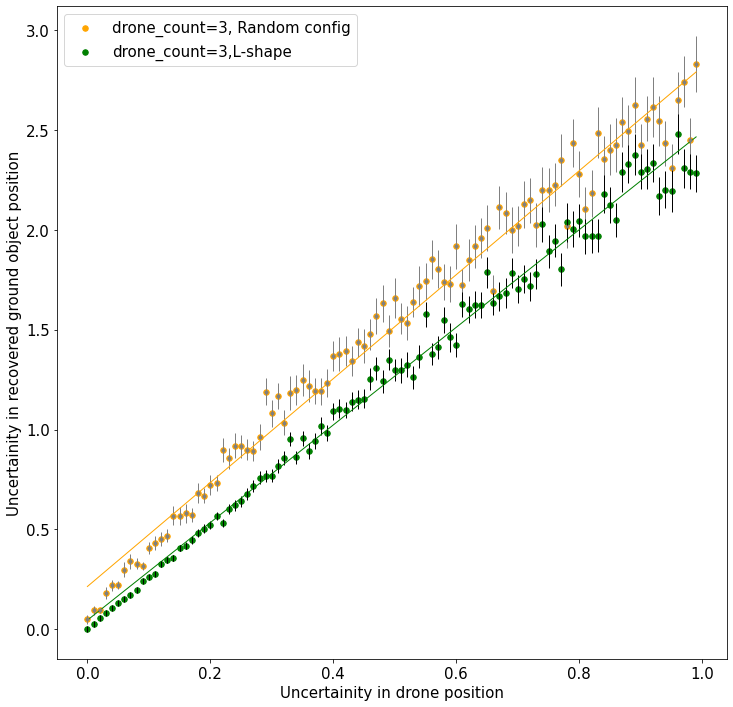

In [37]:
plt.rcParams.update({'font.size': 15})
regr = linear_model.LinearRegression()    
regr.fit(df_results3[['uncer_dp'] ],df_results3[['uncer_rec_go']])  
ax = df_results3.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="orange", label="drone_count=3, Random config",figsize=(12, 12),s=30)
ax.errorbar(df_results3['uncer_dp'] ,df_results3['uncer_rec_go'], yerr=df_results3['std_err_rec_go_pos'], fmt='.', color="grey",elinewidth=1)
plt.plot   (df_results3[['uncer_dp'] ], regr.predict(df_results3[['uncer_dp'] ]), color='orange', linewidth=1)

regr = linear_model.LinearRegression()    
regr.fit(df_results_lshape[['uncer_dp'] ],df_results_lshape[['uncer_rec_go']])  
ax=df_results_lshape.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="green", label="drone_count=3,L-shape", ax=ax,s=30)
ax.errorbar(df_results_lshape['uncer_dp'] ,df_results_lshape['uncer_rec_go'], yerr=df_results_lshape['std_err_rec_go_pos'], fmt='|', color="black",elinewidth=1)
plt.plot   (df_results_lshape[['uncer_dp'] ], regr.predict(df_results_lshape[['uncer_dp'] ]), color='green', linewidth=1)

ax.set_xlabel("Uncertainity in drone position")
ax.set_ylabel("Uncertainity in recovered ground object position")
plt.show()

# Print the uncertainty in ground object position for delta=0.5

In [39]:
df_results3.iloc[50] # Random flight config

uncer_dp              0.500000
uncer_rec_go          1.659278
sd_rec_go_pos         1.428897
std_err_rec_go_pos    0.101292
Name: 50, dtype: float64

In [40]:
df_results_lshape.iloc[50] # L-shaped config

uncer_dp              0.500000
uncer_rec_go          1.299070
sd_rec_go_pos         0.776684
std_err_rec_go_pos    0.055058
Name: 50, dtype: float64